# Exploring all data from a tissue in the Cell Census

The Cell Census is a versioned container for the single-cell data hosted at [CELLxGENE Discover](https://cellxgene.cziscience.com/). The Cell Census utilizes [SOMA](https://github.com/single-cell-data/SOMA/blob/main/abstract_specification.md) powered by [TileDB](https://tiledb.com/products/tiledb-embedded) for storing, accessing, and efficiently filtering data.

This notebook shows you how to learn about the Cell Census contents and what are the available queryable items of it.

This notebook provides a demonstration for:

1. Learning about the lung data.
   1. Learning about cells of lung data.
   1. Larning about genes of lung data.
1. Fetching all human lung data from the Cell Census.
1. Obtaining QC metrics for this data slice.

## Learning about the lung data in the Cell Census

First we open the Cell Census, if you are not familiar with the basics of Cell Census API you should take a look at notebook "Learning about the CELLxGENE Cell Census" at `comp_bio_census_info.ipynb`.

In [1]:
import cell_census
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
census = cell_census.open_soma(census_version="latest")

Let's first take a look at the number of cells from human lung:

In [2]:
summary_table = census["census_info"]["summary_cell_counts"].read_as_pandas_all()
summary_table.query("organism == 'Homo sapiens' & category == 'tissue_general' & label =='lung'")

,soma_joinid,organism,category,ontology_term_id,unique_cell_count,total_cell_count,label
844,844,Homo sapiens,tissue_general,UBERON:0002048,1194348,4351243,lung


You can see that int the human lung there are a total of **4,351,243** cells of which **1,194,348** are unique (i.e. after removing cells that were included in multiple datasets).

Let's now take a look at the cell and gene information of this slice of the Cell Census.

### Learning about cells of lung data

Let's load the cell metadata for all lung cells and select only the unique cells using `is_primary_data`.

In [3]:
lung_obs = census["census_data"]["homo_sapiens"].obs.read_as_pandas_all(value_filter="tissue_general == 'lung'")
lung_obs = lung_obs.query("is_primary_data")
lung_obs

,soma_joinid,dataset_id,assay,assay_ontology_term_id,cell_type,cell_type_ontology_term_id,development_stage,development_stage_ontology_term_id,disease,disease_ontology_term_id,...,is_primary_data,self_reported_ethnicity,self_reported_ethnicity_ontology_term_id,sex,sex_ontology_term_id,suspension_type,tissue,tissue_ontology_term_id,tissue_general,tissue_general_ontology_term_id
876578,5914686,2adb1f8a-a6b1-4909-8ee8-484814e2d4bf,microwell-seq,EFO:0030002,type II pneumocyte,CL:0002063,21-year-old human stage,HsapDv:0000115,normal,PATO:0000461,...,True,Han Chinese,HANCESTRO:0027,male,PATO:0000384,cell,lung,UBERON:0002048,lung,UBERON:0002048
876579,5914687,2adb1f8a-a6b1-4909-8ee8-484814e2d4bf,microwell-seq,EFO:0030002,type II pneumocyte,CL:0002063,21-year-old human stage,HsapDv:0000115,normal,PATO:0000461,...,True,Han Chinese,HANCESTRO:0027,male,PATO:0000384,cell,lung,UBERON:0002048,lung,UBERON:0002048
876580,5914688,2adb1f8a-a6b1-4909-8ee8-484814e2d4bf,microwell-seq,EFO:0030002,type II pneumocyte,CL:0002063,21-year-old human stage,HsapDv:0000115,normal,PATO:0000461,...,True,Han Chinese,HANCESTRO:0027,male,PATO:0000384,cell,lung,UBERON:0002048,lung,UBERON:0002048
876581,5914689,2adb1f8a-a6b1-4909-8ee8-484814e2d4bf,microwell-seq,EFO:0030002,type II pneumocyte,CL:0002063,21-year-old human stage,HsapDv:0000115,normal,PATO:0000461,...,True,Han Chinese,HANCESTRO:0027,male,PATO:0000384,cell,lung,UBERON:0002048,lung,UBERON:0002048
876582,5914690,2adb1f8a-a6b1-4909-8ee8-484814e2d4bf,microwell-seq,EFO:0030002,type II pneumocyte,CL:0002063,21-year-old human stage,HsapDv:0000115,normal,PATO:0000461,...,True,Han Chinese,HANCESTRO:0027,male,PATO:0000384,cell,lung,UBERON:0002048,lung,UBERON:0002048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4351238,33775720,8c42cfd0-0b0a-46d5-910c-fc833d83c45e,10x 3' v2,EFO:0009899,pericyte,CL:0000669,51-year-old human stage,HsapDv:0000145,normal,PATO:0000461,...,True,unknown,unknown,female,PATO:0000383,cell,lung,UBERON:0002048,lung,UBERON:0002048
4351239,33775721,8c42cfd0-0b0a-46d5-910c-fc833d83c45e,10x 3' v2,EFO:0009899,pericyte,CL:0000669,51-year-old human stage,HsapDv:0000145,normal,PATO:0000461,...,True,unknown,unknown,female,PATO:0000383,cell,lung,UBERON:0002048,lung,UBERON:0002048
4351240,33775722,8c42cfd0-0b0a-46d5-910c-fc833d83c45e,10x 3' v2,EFO:0009899,pericyte,CL:0000669,51-year-old human stage,HsapDv:0000145,normal,PATO:0000461,...,True,unknown,unknown,female,PATO:0000383,cell,lung,UBERON:0002048,lung,UBERON:0002048
4351241,33775723,8c42cfd0-0b0a-46d5-910c-fc833d83c45e,10x 3' v2,EFO:0009899,pericyte,CL:0000669,51-year-old human stage,HsapDv:0000145,normal,PATO:0000461,...,True,unknown,unknown,female,PATO:0000383,cell,lung,UBERON:0002048,lung,UBERON:0002048


You can see that there are a total of **1,194,348** unique lung cells in the Cell Census. Now let's take a deeper dive into the characteristics of these cells.

#### Datasets

First let's start by looking at what are the datasets and collections from [CELLxGENE Discover](https://cellxgene.cziscience.com/collections) contributing to lung. For this we will use the dataset table at `census["census-info"]["datasets"]` that contains metadata of all datasets used to build this Cell Census.

In [4]:
census_datasets = census["census_info"]["datasets"].read_as_pandas_all(column_names = ["collection_name", "dataset_title", "dataset_id", "soma_joinid"])
census_datasets = census_datasets.set_index("dataset_id")
census_datasets

,collection_name,dataset_title,soma_joinid
dataset_id,,,
edc8d3fe-153c-4e3d-8be0-2108d30f8d70,Local and systemic responses to SARS-CoV-2 inf...,Airway,0
2a498ace-872a-4935-984b-1afa70fd9886,Local and systemic responses to SARS-CoV-2 inf...,PBMC,1
f512b8b6-369d-4a85-a695-116e0806857f,Transcriptional Programming of Normal and Infl...,Skin,2
fa8605cf-f27e-44af-ac2a-476bee4410d3,Acute COVID-19 cohort across a range of WHO ca...,PBMCs,3
d5c67a4e-a8d9-456d-a273-fa01adb1b308,A single-cell transcriptome atlas of the adult...,Retina,4
...,...,...,...
e0ed3c55-aff6-4bb7-b6ff-98a2d90b890c,A transcriptomic atlas of the mouse cerebellum...,A transcriptomic atlas of the mouse cerebellum,316
e04daea4-4412-45b5-989e-76a9be070a89,A molecular cell atlas of the human lung from ...,"Krasnow Lab Human Lung Cell Atlas, Smart-seq2",317
8c42cfd0-0b0a-46d5-910c-fc833d83c45e,A molecular cell atlas of the human lung from ...,"Krasnow Lab Human Lung Cell Atlas, 10X",318


The `obs` cell metadata `pandas.DataFrame` contains a column `dataset_id` that can be used for joining to the `census_dataset` `pandas.DataFrame`  we just created. 

So let's take a look at the cell counts per `dataset_id` of the lung slice and then join to the dataset table to append the human-readable labels.

In [5]:
dataset_cell_counts = pd.DataFrame(lung_obs[["dataset_id"]].value_counts())
dataset_cell_counts = dataset_cell_counts.rename(columns = {0: "cell_counts"})
dataset_cell_counts = dataset_cell_counts.merge(census_datasets, on ="dataset_id")

dataset_cell_counts

,cell_counts,collection_name,dataset_title,soma_joinid
dataset_id,,,,
066943a2-fdac-4b29-b348-40cede398e4e,278224,The integrated Human Lung Cell Atlas,The integrated Human Lung Cell Atlas,301
f7c1c579-2dc0-47e2-ba19-8165c5a0e353,217738,A human cell atlas of fetal gene expression,Survey of human embryonic development,258
1e6a6ef9-7ec9-4c90-bbfb-2ad3c3165fd1,102115,High-resolution single-cell atlas reveals dive...,The single-cell lung cancer atlas (LuCA) -- ex...,261
576f193c-75d0-4a11-bd25-8676587e6dc2,90384,HTAN MSK - Single cell profiling reveals novel...,Combined samples,231
3dc61ca1-ce40-46b6-8337-f27260fd9a03,71752,A human fetal lung cell atlas uncovers proxima...,All cells,245
8c42cfd0-0b0a-46d5-910c-fc833d83c45e,60993,A molecular cell atlas of the human lung from ...,"Krasnow Lab Human Lung Cell Atlas, 10X",318
2672b679-8048-4f5e-9786-f1b196ccfd08,57019,"scRNA-seq assessment of the human lung, spleen...",Lung Parenchyma,176
9dbab10c-118d-496b-966a-67f1763a6b7d,49014,COVID-19 immune features revealed by a large-s...,Large-scale single-cell analysis reveals criti...,121
3de0ad6d-4378-4f62-b37b-ec0b75a50d94,46500,LungMAP Human data from a broad age healthy d...,Single-cell multiomic profiling of human lungs...,278


We can see that **1,194,348** unique cells come **21** different datasets, and the top collections with lung data are:

1. [The integrated Human Lung Cell Atlas](https://cellxgene.cziscience.com/collections/6f6d381a-7701-4781-935c-db10d30de293) 278,224 cells.
2. [A human cell atlas of fetal gene expression](https://cellxgene.cziscience.com/collections/c114c20f-1ef4-49a5-9c2e-d965787fb90c) 217,738 cells,
3. [High-resolution single-cell atlas reveals diversity and plasticity of tumor-associated neutrophils in non-small cell lung cancer](https://cellxgene.cziscience.com/collections/edb893ee-4066-4128-9aec-5eb2b03f8287) 102,115 cells.
4. [HTAN MSK - Single cell profiling reveals novel tumor and myeloid subpopulations in small cell lung cancer](https://cellxgene.cziscience.com/collections/62e8f058-9c37-48bc-9200-e767f318a8ec) 90,384 cells.
5. [A human fetal lung cell atlas uncovers proximal-distal gradients of differentiation and key regulators of epithelial fates.](https://cellxgene.cziscience.com/collections/2d2e2acd-dade-489f-a2da-6c11aa654028) 71,752 cells.

#### Assays

Let's use a similar logic to take a look at all the assays available for human lung data. Which tells us that most data is from 10x tecnologies and sci-RNA-seq.

In [6]:
lung_obs[["assay"]].value_counts()

assay                                   
10x 3' v2                                   371991
sci-RNA-seq                                 217738
10x 5' v1                                   197647
10x 3' v3                                   187550
BD Rhapsody Whole Transcriptome Analysis    122902
10x 5' v2                                    45798
microwell-seq                                33698
Smart-seq2                                   10247
10x 3' transcription profiling                3857
10x 3' v1                                     2920
dtype: int64

#### Disease

And now let's take a look at diseased cell counts, `normal` is non-diseased cells.

In [7]:
lung_obs[["disease"]].value_counts()

disease                     
normal                          944311
lung adenocarcinoma             132967
COVID-19                         49014
squamous cell lung carcinoma     36516
small cell lung carcinoma        31540
dtype: int64

#### Sex

There doesn't seem to be strong biases for sex.

In [8]:
lung_obs[["sex"]].value_counts()

sex    
male       645694
female     548464
unknown       190
dtype: int64

#### Cell vs nucleus

The majority of data from from cells and not nucleus.

In [9]:
lung_obs[["suspension_type"]].value_counts()

suspension_type
cell               894826
nucleus            299522
dtype: int64

#### Cell types

Let's take a look at the counts of the top 20 cell types.

In [10]:
lung_obs[["cell_type"]].value_counts().head(20)

cell_type                                 
alveolar macrophage                           118184
epithelial cell of lower respiratory tract    101249
type II pneumocyte                             99444
stromal cell                                   87301
macrophage                                     56132
CD4-positive, alpha-beta T cell                43949
natural killer cell                            43290
T cell                                         40789
CD8-positive, alpha-beta T cell                40310
fibroblast of lung                             36967
epithelial cell                                35636
classical monocyte                             25267
elicited macrophage                            23525
endothelial cell                               22528
epithelial cell of alveolus of lung            22305
fibroblast                                     20537
type I pneumocyte                              19291
neutrophil                                     16971
mon

#### Sub-tissues

We can look at the original tissue annotations that were mapped to "lung".

In [11]:
lung_obs[["tissue"]].value_counts()

tissue                 
lung                       812762
lung parenchyma            335243
lingula of left lung        35284
lower lobe of left lung     11059
dtype: int64

### Learning about genes of lung data

Let's load the gene metadata of the Cell Census.

In [12]:
lung_var = census["census_data"]["homo_sapiens"].ms["RNA"].var.read_as_pandas_all()
lung_var

,soma_joinid,feature_id,feature_name,feature_length
0,0,ENSG00000121410,A1BG,3999
1,1,ENSG00000268895,A1BG-AS1,3374
2,2,ENSG00000148584,A1CF,9603
3,3,ENSG00000175899,A2M,6318
4,4,ENSG00000245105,A2M-AS1,2948
...,...,...,...,...
60549,60549,ENSG00000285989,H2AQ1P,303
60550,60550,ENSG00000285470,TUSC2P1,1237
60551,60551,ENSG00000286120,AC006158.7,457
60552,60552,ENSG00000286173,AC006158.9,457


You can see that there is a total of **60,554** genes. This number is actually misleading becausue it is the join of all genes in the Cell Census. However we know that the lung data comes from **21** datasets. 

So let's take a look at the number of genes that were measured in each of those datasets.

To accomplish this we can use the "dataset presence matrix" at `census["census_data"]["homo_sapiens"].ms["RNA"].varp["dataset_presence_matrix"]`. This is a boolean matrix `N x M` where `N` is the number of datasets and `M` is the number of genes in the Cell Census. 

So we can select the rows corresponding to the lung datasets and perform a row-wise sum.

In [13]:
presence = census["census_data"]["homo_sapiens"].ms["RNA"].varp["dataset_presence_matrix"]

arrow_sparse_tensors = [t for t in presence.read_sparse_tensor((slice(None),))]
flat_arrays = [t.to_numpy() for t in arrow_sparse_tensors]
data = np.concatenate(tuple(t[0] for t in flat_arrays))
coords = np.concatenate(tuple(t[1] for t in flat_arrays))
presence_matrix = coo_matrix(
    (data.flatten(), (coords.T[0].flatten(), coords.T[1].flatten())), shape=presence.shape
).tocsr()

presence_matrix = presence_matrix[dataset_cell_counts.soma_joinid,:]

In [14]:
genes_measured = []
for i in range(presence_matrix.shape[0]):
    genes_measured.append(presence_matrix[i,:].count_nonzero())
    
dataset_cell_counts["genes_measured"] = genes_measured
dataset_cell_counts

,cell_counts,collection_name,dataset_title,soma_joinid,genes_measured
dataset_id,,,,,
066943a2-fdac-4b29-b348-40cede398e4e,278224,The integrated Human Lung Cell Atlas,The integrated Human Lung Cell Atlas,301,28024
f7c1c579-2dc0-47e2-ba19-8165c5a0e353,217738,A human cell atlas of fetal gene expression,Survey of human embryonic development,258,44150
1e6a6ef9-7ec9-4c90-bbfb-2ad3c3165fd1,102115,High-resolution single-cell atlas reveals dive...,The single-cell lung cancer atlas (LuCA) -- ex...,261,17811
576f193c-75d0-4a11-bd25-8676587e6dc2,90384,HTAN MSK - Single cell profiling reveals novel...,Combined samples,231,22447
3dc61ca1-ce40-46b6-8337-f27260fd9a03,71752,A human fetal lung cell atlas uncovers proxima...,All cells,245,26347
8c42cfd0-0b0a-46d5-910c-fc833d83c45e,60993,A molecular cell atlas of the human lung from ...,"Krasnow Lab Human Lung Cell Atlas, 10X",318,20921
2672b679-8048-4f5e-9786-f1b196ccfd08,57019,"scRNA-seq assessment of the human lung, spleen...",Lung Parenchyma,176,24672
9dbab10c-118d-496b-966a-67f1763a6b7d,49014,COVID-19 immune features revealed by a large-s...,Large-scale single-cell analysis reveals criti...,121,27705
3de0ad6d-4378-4f62-b37b-ec0b75a50d94,46500,LungMAP Human data from a broad age healthy d...,Single-cell multiomic profiling of human lungs...,278,26323


Now lets get the **genes that were measured in all datasets**.

In [15]:
var_somaid = []
for j in range(presence_matrix.shape[1]):
    dataset_count = presence_matrix[:,j].count_nonzero()
    if dataset_count == presence_matrix.shape[0]:
        var_somaid.append(j)

In [16]:
lung_var = lung_var.query(f"soma_joinid in {var_somaid}")
lung_var

,soma_joinid,feature_id,feature_name,feature_length
0,0,ENSG00000121410,A1BG,3999
3,3,ENSG00000175899,A2M,6318
9,9,ENSG00000128274,A4GALT,3358
11,11,ENSG00000094914,AAAS,4727
12,12,ENSG00000081760,AACS,16039
...,...,...,...,...
33226,33226,ENSG00000198205,ZXDA,5029
33227,33227,ENSG00000198455,ZXDB,5467
33228,33228,ENSG00000070476,ZXDC,7329
33230,33230,ENSG00000162378,ZYG11B,8206


You can see that there are a total of **11,948** genes that were measured in all lung datasets.

### Summary of lung metadata

In the previous sections, using the Cell Census we learned the following information:

- There are **1,194,348** unique lung cells and those are composed of:
    - **21** datasets.
    - **10** sequencing technologies, most of which are 10x
    - **
    - Mostly human data, but **4** diseases exists, primarily "lung adenocarcinoma" (**132,967** cells) and "COVID=19" (**49,014** cells)
    - No sex biases.
    - Most data is from cells(~80%) rather than nucleus (~20%)
- A total of **11,948** genes were measured across all cells.
    
## Fetching all human lung data from the Cell Census.

Now let's try to load all data into an `anndata.AnnData` object and select only the unique cells using `is_primary_data`.

We will also only select lung cells and the genes measure in all lung datasets that we obtained in the sections above.

In [17]:
lung_genes = list(lung_var["feature_id"])
lung_adata = cell_census.get_anndata(census, 
                                     organism = "Homo sapiens", 
                                     obs_query = {"tissue_general": "lung", "is_primary_data": True},
                                     var_query = {"feature_id": lung_genes}
                                    )

lung_adata.var_names = lung_adata.var["feature_name"]

### QC metrics on gene expression of all Lung data

Now let's take a look at some QC metrics

**Top genes per cell**

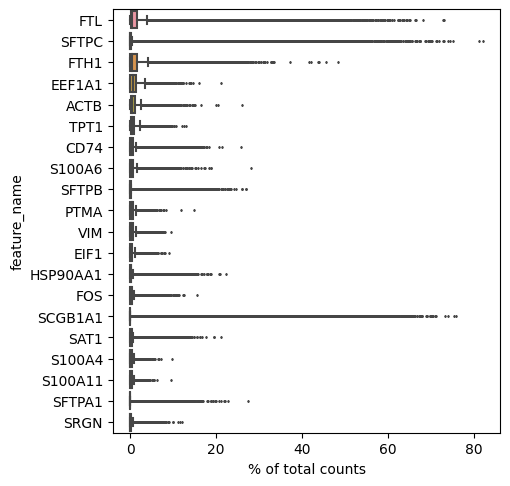

In [18]:
sc.pl.highest_expr_genes(lung_adata, n_top=20)

**Number of sequenced genes by assay**

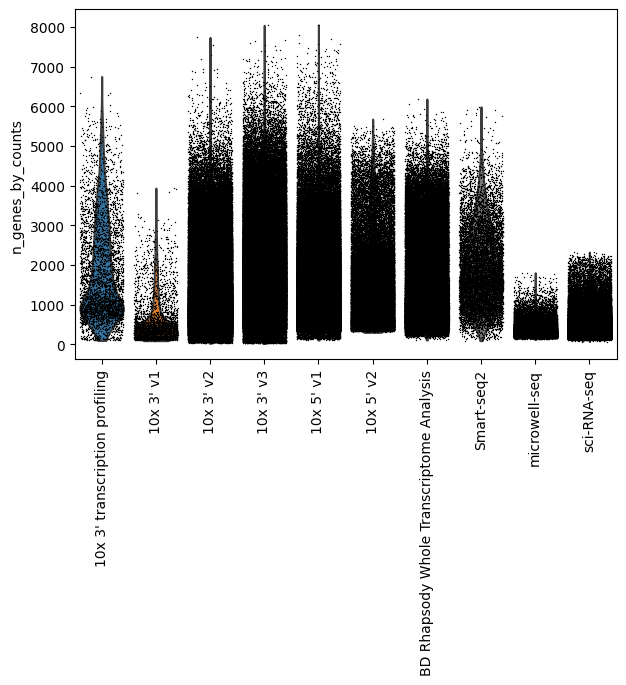

In [19]:
sc.pp.calculate_qc_metrics(lung_adata, percent_top=None, log1p=False, inplace=True)
sc.pl.violin(lung_adata,'n_genes_by_counts', groupby = "assay",
             jitter=0.4, rotation=90)

**Total counts by assay**

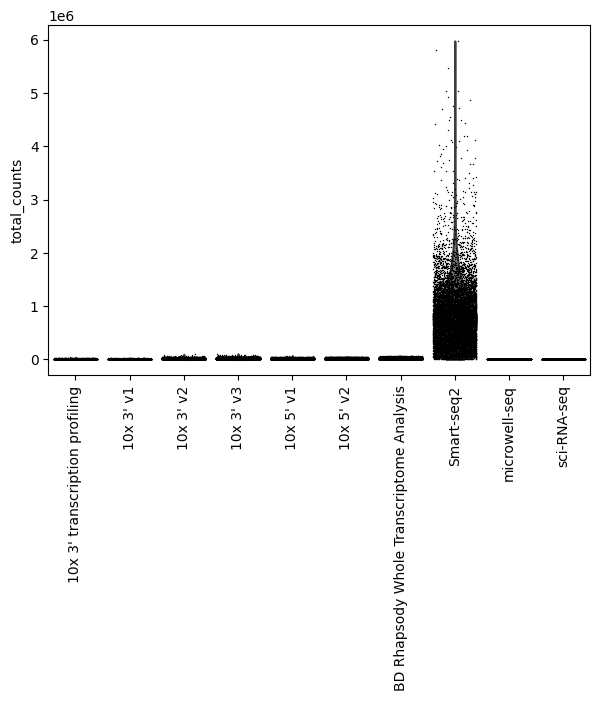

In [20]:
sc.pl.violin(lung_adata,'total_counts', groupby = "assay",
             jitter=0.4, rotation=90)

You can see that Smart-Seq2 is an outlier for the total counts per cell, so let's exlcude it to see how the rest of the assays look like

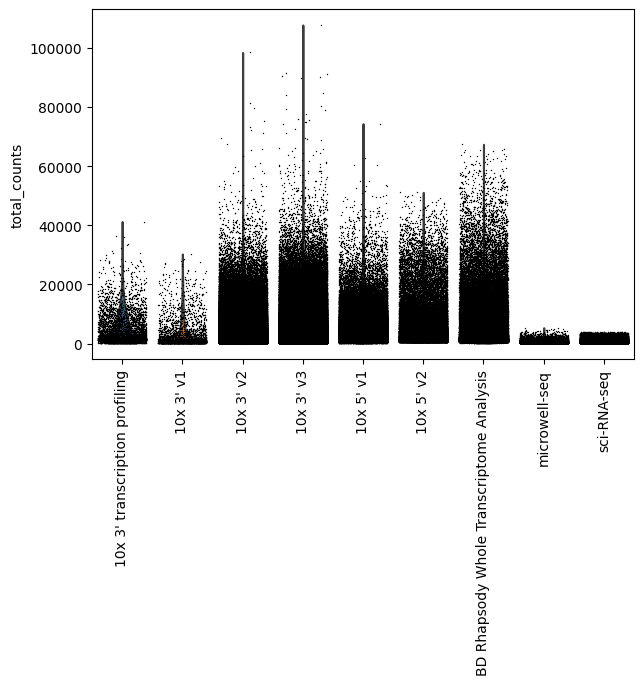

In [21]:
sc.pl.violin(lung_adata[lung_adata.obs["assay"] != "Smart-seq2",], 'total_counts', groupby = "assay",
             jitter=0.4, rotation=90)

### Quick normalization and embeddings

Let's perform a bread and butter normalization and take a look at UMAP embeddings, but for all the data below we'll exclude Smart-seq2 as this requires an extra step to normalize based on gene lengths

In [22]:
lung_adata = lung_adata[lung_adata.obs["assay"] != "Smart-seq2",].copy()
lung_adata.layers["counts"] = lung_adata.X

Now let's do some basic normalization:

- Normalize by sequencing depth
- Transform to log-scale
- Select 500 highly variable genes
- Scale values across the gene axis

In [23]:
sc.pp.normalize_total(lung_adata, target_sum=1e4)
sc.pp.log1p(lung_adata)
sc.pp.highly_variable_genes(lung_adata, n_top_genes = 500, flavor = "seurat_v3", layer = "counts")
lung_adata = lung_adata[:, lung_adata.var.highly_variable]
sc.pp.scale(lung_adata, max_value=10)

/home/ubuntu/repos/TileDB-SOMA/test/tiledbsoma/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/home/ubuntu/repos/TileDB-SOMA/test/tiledbsoma/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


And reduce dimensionality by obtaining UMAP embeddings.

In [24]:
sc.tl.pca(lung_adata)
sc.pp.neighbors(lung_adata)
sc.tl.umap(lung_adata)

And plot these embeddings.

In [25]:
n_cell_types = len(lung_adata.obs["cell_type"].drop_duplicates())

from random import randint
colors = []

for i in range(len(lung_adata.obs["cell_type"].drop_duplicates())):
    colors.append('#%06X' % randint(0, 0xFFFFFF))

/home/ubuntu/repos/TileDB-SOMA/test/tiledbsoma/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


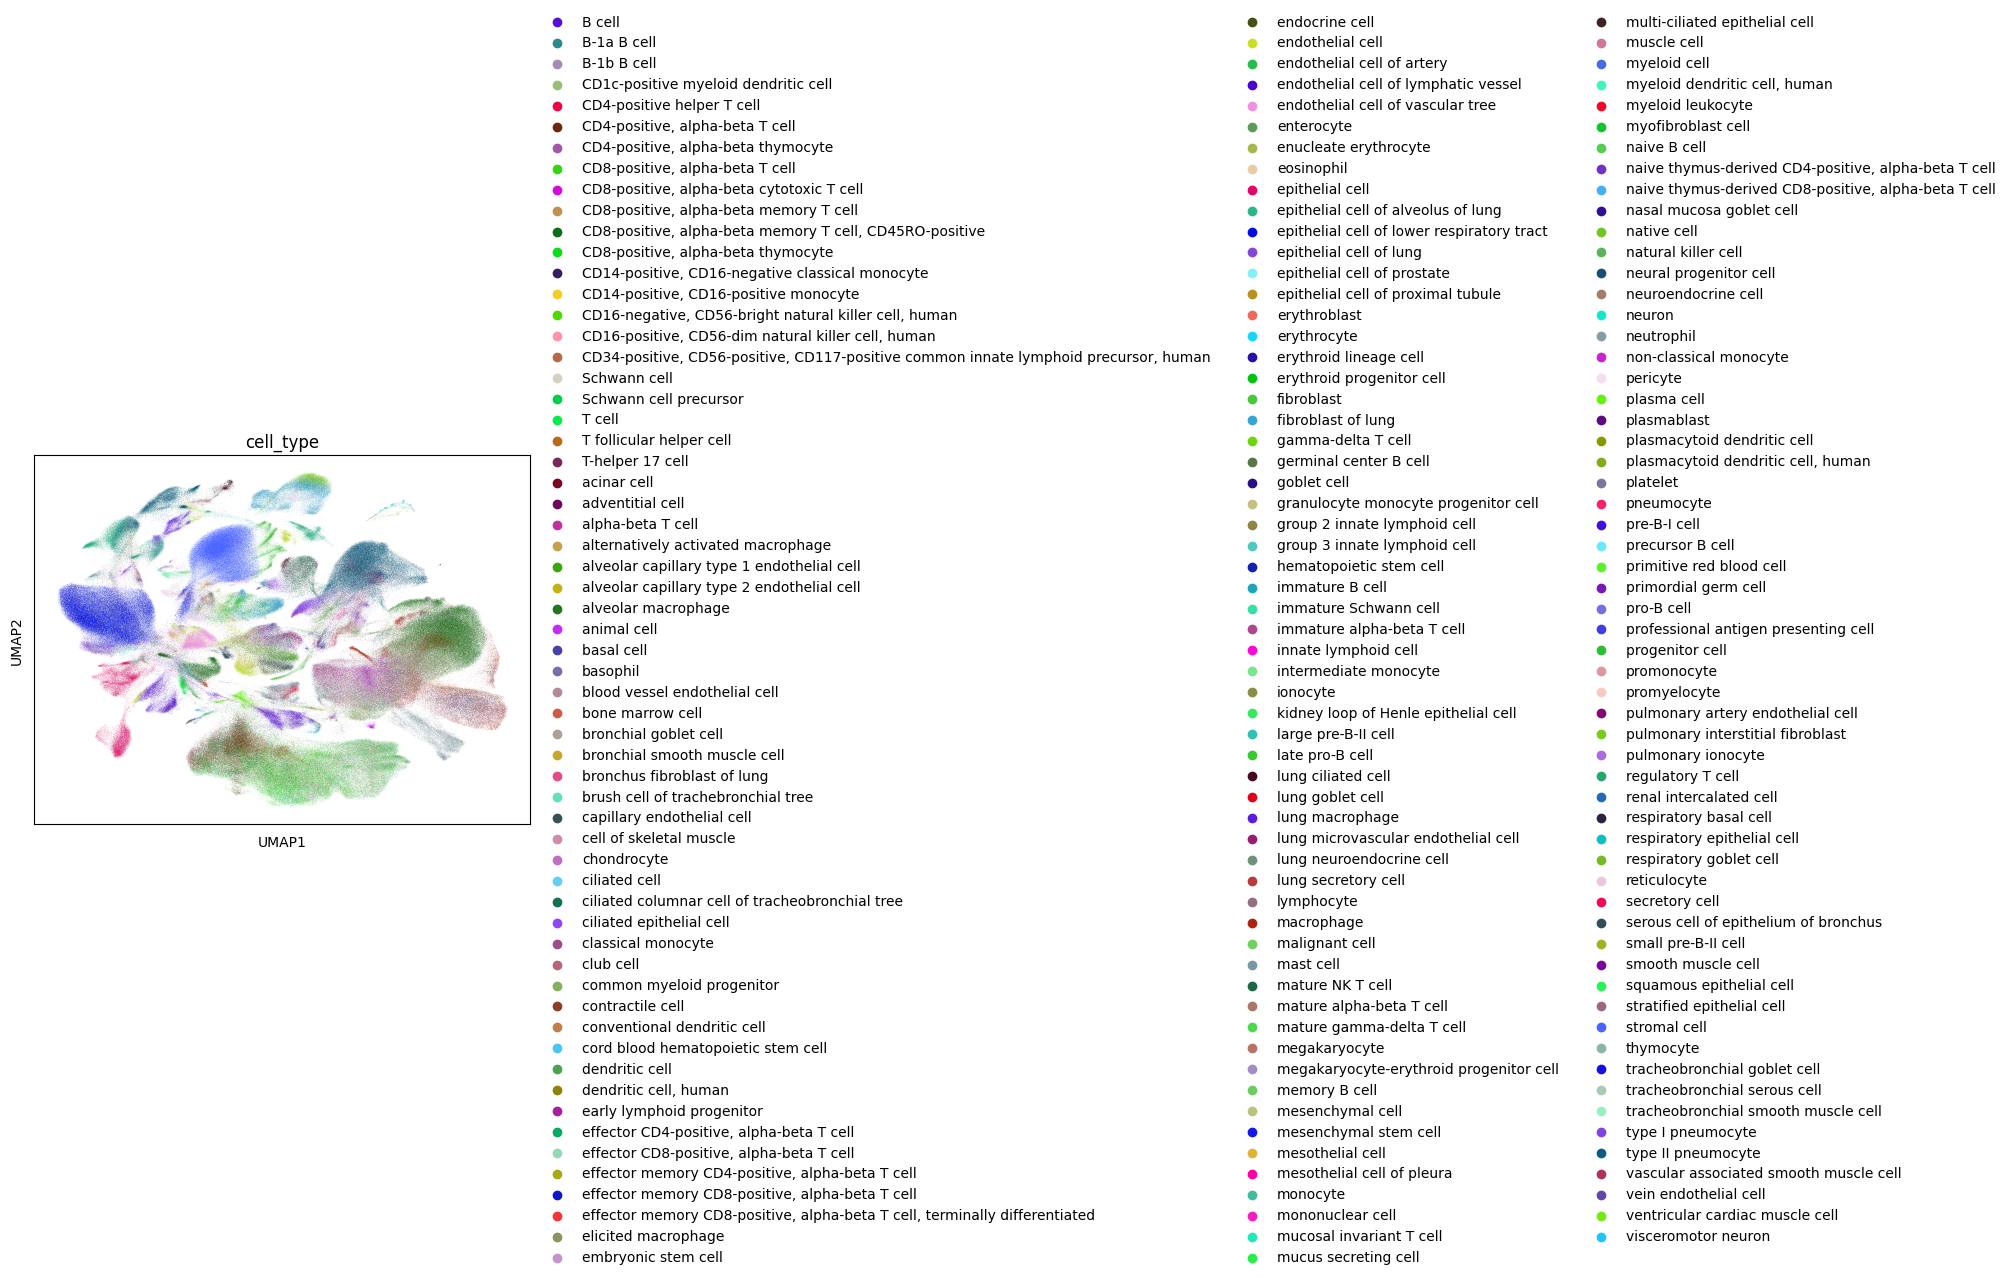

In [26]:
sc.pl.umap(lung_adata, color="cell_type", palette = colors)

/home/ubuntu/repos/TileDB-SOMA/test/tiledbsoma/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


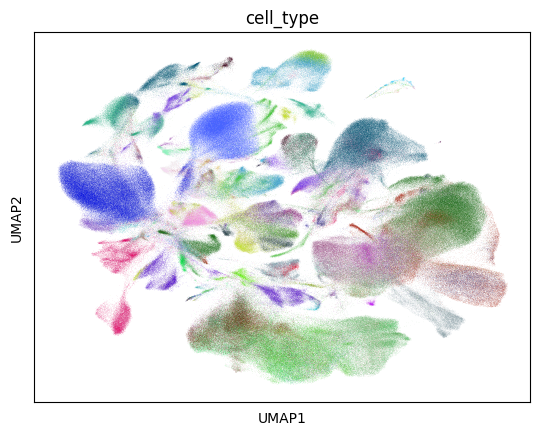

In [27]:
sc.pl.umap(lung_adata, color="cell_type", palette = colors, legend_loc = None)

Let's color by assay.

/home/ubuntu/repos/TileDB-SOMA/test/tiledbsoma/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


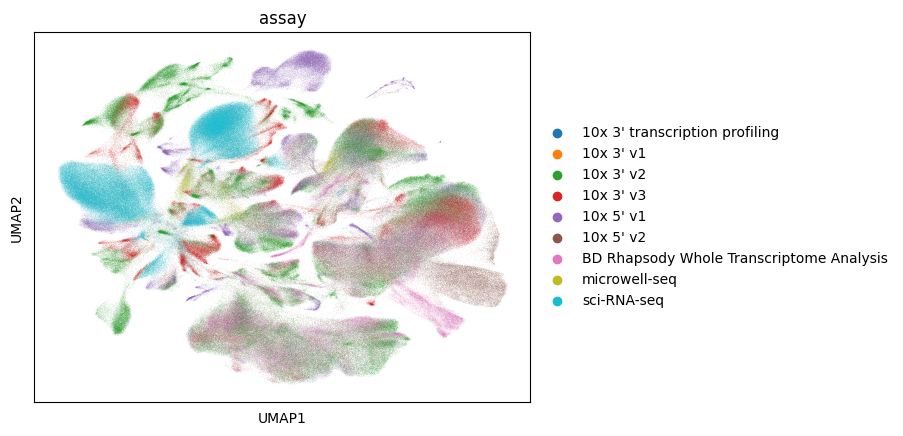

In [29]:
sc.pl.umap(lung_adata, color="assay")

Given the high number of cell types it makes it hard to visualize, so let's look at the top 20 most abundant cell types.

In [30]:
top_cell_types = lung_adata.obs["cell_type"].value_counts()
top_cell_types = list(top_cell_types.reset_index().head(20)["index"])

/home/ubuntu/repos/TileDB-SOMA/test/tiledbsoma/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


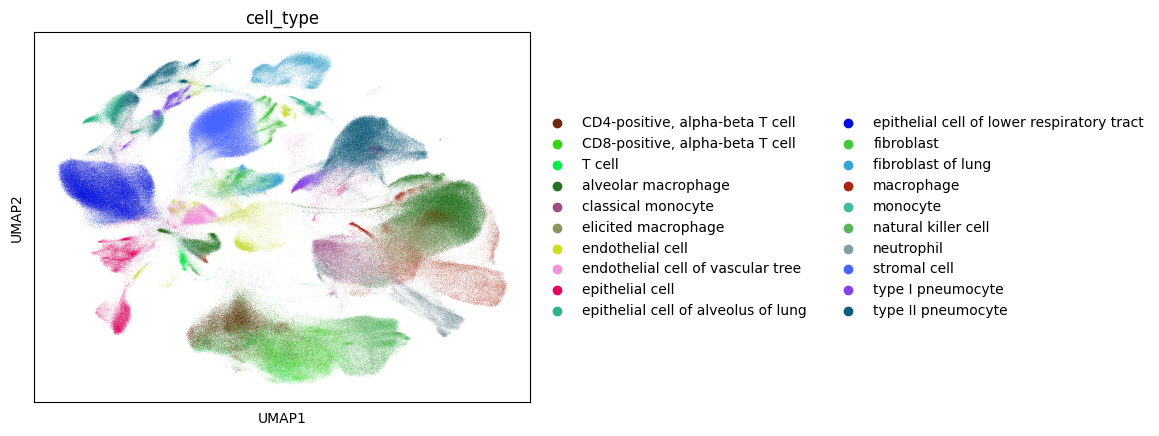

In [31]:
lung_adata_top_cell_types = lung_adata[[i in top_cell_types for i in lung_adata.obs["cell_type"]], :]
sc.pl.umap(lung_adata_top_cell_types, color="cell_type")

Let's color by assay of this subset of the data.

/home/ubuntu/repos/TileDB-SOMA/test/tiledbsoma/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


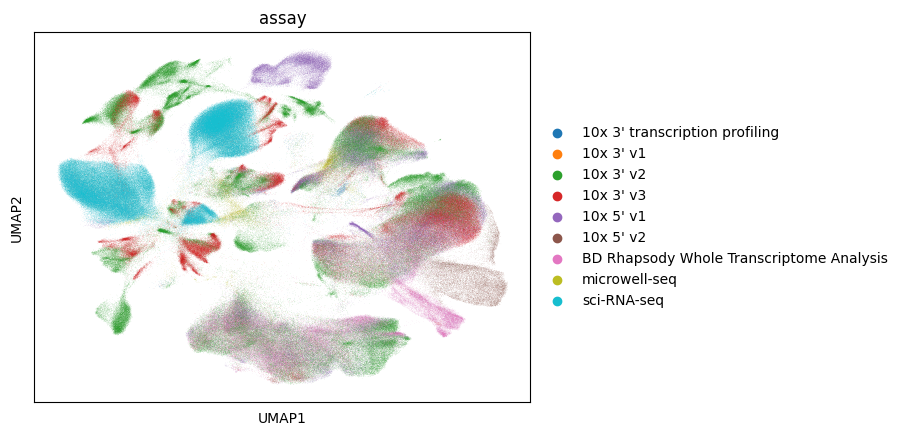

In [32]:
sc.pl.umap(lung_adata_top_cell_types, color="assay")